# Poker Parser

### Import functions

In [756]:
import os

In [758]:
os.system('jupyter nbconvert --to html Poker_Parser.ipynb')

0

In [747]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime
import pytz

def find(s, ch):
    return np.array([i for i, ltr in enumerate(s) if ltr == ch]).astype(int)

### Load and process data

In [748]:
dfraw = pd.read_csv('data_03_12_20.csv').reset_index(drop=True)
df = dfraw[dfraw['entry'].str.contains('Player stacks')].reset_index(drop=False)
df = df.rename(columns={'index':'original_index'})

In [749]:
for irow in range(len(df)):
    s = df.loc[irow,'entry']
    name_starts = find(s,'"')[::2]+1
    name_ends   = find(s,'@')-1
    num_starts  = find(s,'(')+1
    num_ends    = find(s,')')
    for iname in range(len(name_starts)):
        name = s[name_starts[iname]:name_ends[iname]]
        num  = s[num_starts[iname]:num_ends[iname]]
        df.loc[irow,name] = float(num)

names = [n for n in df.columns if n not in ['entry','at','order','original_index']]
for n in names:
    df[n+'_buybacks'] = 0
    df[n+'_buyback_total'] = 0
    
df = df[::-1].reset_index(drop=True)

### Account for buy-backs

In [750]:
buyback_rows = dfraw[dfraw['entry'].str.contains('joined')].reset_index(drop=False)
buyback_rows = buyback_rows.rename(columns={'index':'original_index'})[:-len(names)]

for i in list(range(len(buyback_rows)))[::-1]:
    etr = buyback_rows.loc[i,'entry']
    name = etr[etr.index('"')+1:etr.index('@')-1]
    num = etr[etr.index('of')+3:-1]
    at = buyback_rows.loc[i,'at'].replace('T',' ')
    time = at[at.index(':')-2:at.index(':')+3]
    yn = 0
    while yn not in ['y','n']:
        yn = input(f'Did {name} buy back in for {num} at {time}? [y/n]')
    buyback_rows.loc[i,'is_buyback'] = (yn=='y')
    buyback_rows.loc[i,'amount'] = float(num)
    buyback_rows.loc[i,'name'] = name

Did Dr. Hurst buy back in for 2.35 at 20:47? [y/n] n
Did Dr. Hurst buy back in for 3.50 at 21:30? [y/n] y


In [751]:
for i in range(len(buyback_rows)):
    if not buyback_rows.loc[i,'is_buyback']:
        continue
    # < since we have inverted df 
    ind = buyback_rows.loc[i,'original_index']
    amount = buyback_rows.loc[i,'amount']
    name = buyback_rows.loc[i,'name']
    df.loc[df['original_index']<ind, name] -= amount
    df.loc[df['original_index']<ind, name+'_buybacks'] += 1
    df.loc[df['original_index']<ind, name+'_buyback_total'] += amount

In [752]:
for nam in names:
    nanrows = df[pd.isnull(df[nam])]
    nanrows = nanrows.loc[[ind for ind in nanrows.index if ind-1 not in nanrows.index]]
    for i_n in range(len(nanrows)):
        index_of_row = nanrows.iloc[[i_n]].index[0]
        inbb = nanrows.loc[index_of_row, name+'_buybacks']
        for i_df in range(index_of_row, len(df)):
            if not np.isnan(df.loc[i_df, name]):
                if df.loc[i_df, name+'_buybacks'] == inbb+1:
                    inds_to_fill = list(range(index_of_row,i_df+1))
                    df.loc[inds_to_fill, name] = -nanrows.loc[index_of_row, name+'_buyback_total']
                break
        else:
            inds_to_fill = list(range(index_of_row,len(df)))
            df.loc[inds_to_fill, name] = -nanrows.loc[index_of_row, name+'_buyback_total']
df = df.bfill()

# Not inds that have no change = some error in accounting
inds_to_keep = [0] 
for i in range(1, len(df)):
    for nam in names:
        if df.loc[i, nam]!=df.loc[i-1, nam]:
            inds_to_keep.append(i)
            break
df = df.loc[inds_to_keep, names+['at']].reset_index(drop=True)

### Colour tester

['darkmagenta', 'forestgreen', 'coral'] 



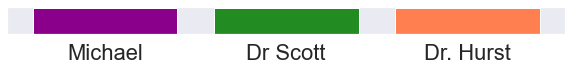

In [753]:
from matplotlib import colors as mcolors
cols = list(mcolors.CSS4_COLORS.keys())
cols = [c for c in cols if 'white' not in c]
np.random.shuffle(cols)

# Suggested colour scheme. Comment this line out to try random schemes.
cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise']

plt.figure(figsize=[10,0.5])
for i,n in enumerate(names):
    plt.bar([names[i]], [1], color=cols[i])
    plt.xticks(rotation=0);
    plt.yticks([]);
print(cols[:len(names)], '\n')

# Some good colour schemes
# cols = ['mediumturquoise', 'grey', 'red', 'darkmagenta']
# cols = ['forestgreen', 'orange', 'purple', 'cornflowerblue']
# cols = ['darkmagenta', 'forestgreen', 'coral', 'darkturquoise']

### Plot total bankroll over time

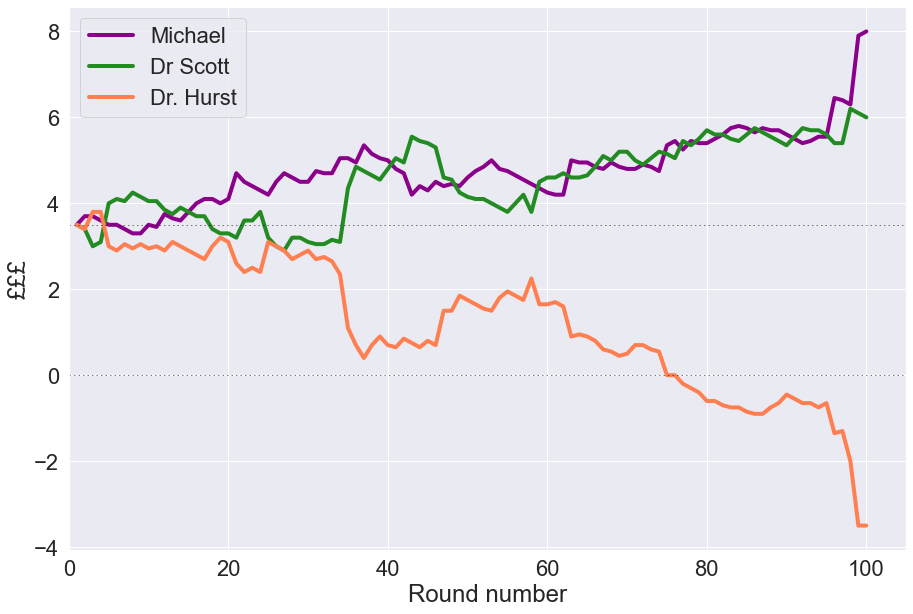

In [754]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)
for i,n in enumerate(names):
    plt.plot(np.arange(1,len(df)+1),df[n].values,label=n,color=cols[i],linewidth=4)
plt.legend()
plt.xlabel('Round number')
plt.ylabel('£££')
plt.xlim(left=0);
plt.gca().axhline(0,dashes=[3,6],linewidth=.5,color='black')
plt.gca().axhline(df.loc[0,names[0]],dashes=[3,6],linewidth=.5,color='black')

plt.savefig(f'poker_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')

### Plot winnings and losses per round

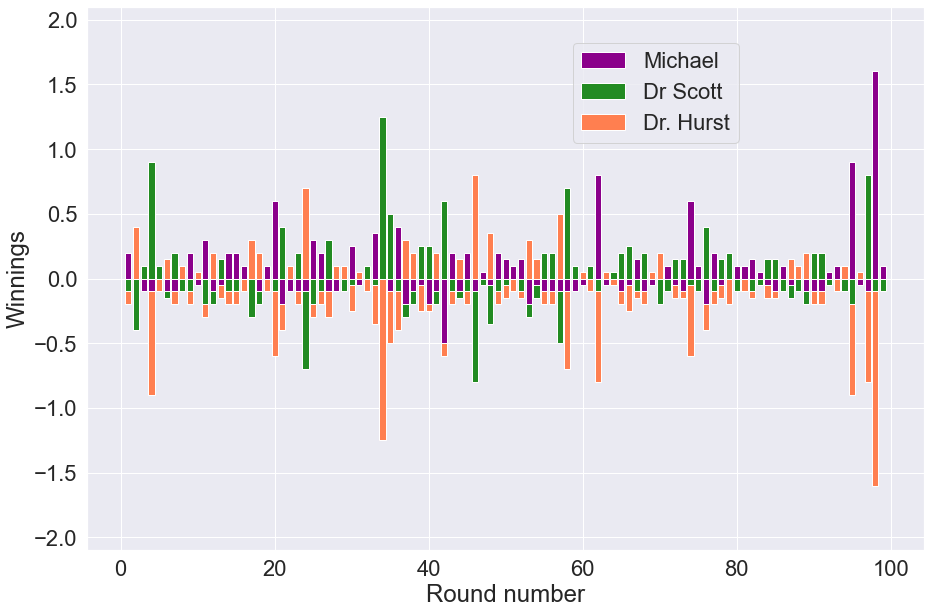

In [755]:
plt.figure(figsize=[15,10])
sns.set(font_scale=2)

previous = (np.arange(1,len(df))*0).astype(float)
for i,n in enumerate(names):
    diffs = np.diff(df[n])

    above_part = np.where(diffs>0, diffs, 0)
    plt.bar(np.arange(1,len(df)),above_part,color=cols[i], label=n, alpha=1)

    bottom_part = np.diff(df[n])
    bottom_part = np.where(diffs<0, -diffs, 0)
    previous-=bottom_part

    inds = np.where(bottom_part!=0)[0]
    y_plot = bottom_part[inds]
    x_plot = np.arange(1,len(df))[inds] 
    plt.bar(x_plot,y_plot,bottom=previous[inds],color=cols[i], alpha=1)


plt.legend(loc=[0.58,.75])
plt.xlabel('Round number')
plt.ylabel('Winnings')
range_ = -min(previous)+0.5
plt.ylim((-range_,range_));

plt.savefig(f'winnings_{datetime.now().strftime("%d_%m_%y")}.png',bbox_inches='tight')